### TP 2 VISIÓN POR COMPUTADORA.

Integrantes: 

- Lara Rosenberg
- Victoria Terán
- Fernando Vasconcelos



# Objetivo
### Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [1]:
# Importamos las librerias necesarias
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib
import math
from typing import List


In [2]:
# Ruta del video
video_path = 'video/focus_video.mov'

#### Definimos funciones auxiliares

In [3]:
# Definimos una clase para el manejo de la región de interes
class Roi:

    # Define tamaño de la ROI en función a los parametros de entrada (Porcentaje del frame o ancho y alto de la roi)
    def __init__(self, frame_height: int, frame_width: int, roi: float = 1, height: int = 1, width: int = 1) -> None:
        if roi > 1 or roi <= 0:
            raise ValueError('roi is out of range')

        self.roi = roi
        self.frame_height = frame_height
        self.frame_width = frame_width

        if roi == 1:
            if height > frame_height or width > frame_width:
                raise ValueError('Height/width of the image must be less than the frame height/width')
            self.height = height
            self.width = width
        else:
            # Guardamos el ancho y largo del roi 
            self.height = int(frame_height * math.sqrt(self.roi))
            self.width = int(frame_width * math.sqrt(self.roi))

        self.y_start = (frame_height - self.height) // 2
        self.y_end = self.y_start + self.height
        self.x_start = (frame_width - self.width) // 2
        self.x_end = self.x_start + self.width

    # Devuelve la ROI del frame 
    def apply(self, image: np.array) -> np.array:
        return image[self.y_start:self.y_start + self.height, self.x_start:self.x_start + self.width]

    # Devuelve el rectangulo de la roi
    def get_rectangle(self, color=(0, 255, 0)):
        overlay = np.zeros((self.frame_height, self.frame_width, 3), dtype=np.uint8)
        
        return cv2.rectangle(overlay, (self.x_start, self.y_start), (self.x_end, self.y_end), color, 2)

In [4]:
class Matrix:
    def __init__(self, frame_height: int, frame_width: int, height: int, width: int, nrows: int = 3,
                 ncols: int = 3) -> None:
        if height > frame_height or width > frame_width:
            raise ValueError('Height/width of the image must be less than the frame height/width')
        self._frame_height = frame_height
        self._frame_width = frame_width
        self._height = height
        self._width = width

        self.y_start = (frame_height - self._height) // 2
        self.y_end = self.y_start + self._height
        self.x_start = (frame_width - self._width) // 2
        self.x_end = self.x_start + self._width

        self._nrows = nrows
        self._ncols = ncols
        # Calcular el tamaño de cada rectángulo
        self._rect_width = self._width // (2 * ncols - 1)
        self._rect_height = self._height // (2 * nrows - 1)

        # Para que los rectangulos esten equidistantes calculamos el margen minimo y ajustamos el lado 
        if self._rect_width < self._rect_height:
            self._margin = self._rect_width
            self._rect_height = (self._height - self._margin * (self._nrows - 1)) // self._nrows
        else:
            self._margin = self._rect_height
            self._rect_width = (self._width - self._margin * (self._ncols - 1)) // self._ncols

        # Creamos los rectangulos y almacenamos las coordenadas en una lista de tupllas
        self._box_list = list()
        for i in range(nrows):
            for j in range(ncols):
                # Calcular las coordenadas del rectángulo
                x_start = self.x_start + j * (self._rect_width + self._margin)
                y_start = self.y_start + i * (self._rect_height + self._margin)

                x_end = x_start + self._rect_width
                y_end = y_start + self._rect_height

                self._box_list.append((x_start, y_start, x_end, y_end))

    def apply(self, image: np.array) -> np.array:
        frame_box_list = list()
        for box in self._box_list:
            x_start, y_start, x_end, y_end = box
            frame_box_list.append(image[y_start:y_end, x_start:x_end])
        return frame_box_list

    def get_focus_matrix(self, color=(0, 255, 0)) -> np.array:
        overlay = np.zeros((self._frame_height, self._frame_width, 3), dtype=np.uint8)
        for box in self._box_list:
            x_start, y_start, x_end, y_end = box
            cv2.rectangle(overlay, (x_start, y_start), (x_end, y_end), color, 2)
        return overlay


In [5]:
# Definimos una clase para el manejo de la visualización del video 
class VideoPlayer:
    # Inicializamos la lectura del video y parametros
    def __init__(self, file: str) -> None:
        self.video = cv2.VideoCapture(video_path)
        if not self.video.isOpened():
            raise IOError('Video\'s not opened')
        self._frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self._frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self._frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        self._fps = int(self.video.get(cv2.CAP_PROP_FPS))

        self._roi = None
        self._is_roi_set = False
        self._osd_color = (0, 255, 0)
        self._matrix = None
        self._is_matrix_set = False
        self._matrix_row = 3
        self._matrix_col = 3
        self._current_frame = None
        self._is_osd = False

    # Creamos una ROI (si ya existe se elimina y se vuelve a crear)
    def set_roi(self, roi: float = 1, height: int = 1, width: int = 1, nrows: int = 3,
                ncols: int = 3) -> None:
        self.unset_matrix()
        # Si hay una roi la elimino
        self.unset_roi()
        self._roi = Roi(self._frame_height, self._frame_width, roi=roi, height=height, width=width)
        self._is_roi_set = True
        # Eliminamos la ROI si ya existe

    def unset_roi(self):
        if self._is_roi_set and self._roi:
            del self._roi
            self._is_roi_set = False

    @property
    def is_roi_set(self):
        return self._is_roi_set
    
    def osd_on(self):
        self._is_osd = True

    def osd_off(self):
        self._is_osd = False
        
    def set_osd_color(self, color):
        self._osd_color = color
        
    # Devuelve la ROI del frame si existe. De no existir, devuelve el frame completo
    def get_roi_frame(self) -> np.array:
        if not self._is_roi_set:
            return cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY)
        return self._roi.apply(cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY))

    def set_matrix(self, height: int, width: int, show_matrix: bool = True, nrows: int = 3, ncols: int = 3) -> None:
        self.unset_roi()
        self.unset_matrix()
        self._matrix = Matrix(self._frame_height, self._frame_width, height, width, nrows, ncols)
        self._is_matrix_set = True

    # Eliminamos la Matriz si ya existe
    def unset_matrix(self):
        if self._is_matrix_set and self._matrix:
            del self._matrix
            self._is_matrix_set = False

    @property
    def is_matrix_set(self):
        return self._is_matrix_set

    def get_matrix_frames(self) -> List[np.array]:
        if not self._is_matrix_set:
            return cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY)
        return self._matrix.apply(cv2.cvtColor(self._current_frame, cv2.COLOR_BGR2GRAY))

    @property
    def shape(self):
        return self._frame_height, self._frame_width

    @property
    def fps(self):
        return self._fps

    @fps.setter
    def fps(self, value):
        self._fps = value

    @property
    def frame_count(self):
        return self._frame_count

    @frame_count.setter
    def frame_count(self, value):
        self._frame_count = value

    # Devuelve el frame. En caso de existir matriz de enfoque se la agrega
    def get_frame(self) -> np.array:
        ret, self._current_frame = self.video.read()
        if not ret:
            return None
        result = self._current_frame
        if self._is_osd:
            if self._is_roi_set:
                roi_rectangle = self._roi.get_rectangle(self._osd_color)
                result = cv2.bitwise_or(roi_rectangle, self._current_frame)
            elif self._is_matrix_set:
                focus_matrix = self._matrix.get_focus_matrix(self._osd_color)
                result = cv2.bitwise_or(focus_matrix, self._current_frame)

        return result

    def get_current_frame(self) -> np.array:
        return self._current_frame
    
    # Devuelve el frame de un indice determinado
    def get_frame_by_index(self, index: int) -> np.array:
        self.set_video_pos(index)
        return self.get_frame()

    # Reinicia el video
    def restart(self):
        self.osd_off()
        self.unset_roi()
        self.unset_matrix()
        self.video.set(cv2.CAP_PROP_POS_FRAMES, 0)

    # Mueve el puntero al indice determinado
    def set_video_pos(self, frame_index):
        if frame_index < 1 or frame_index > self._frame_count:
            raise ValueError('Frame index out of range')
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_index - 1)

    # Devuelve la posición del frame actual
    def get_video_pos(self):
        return int(self.video.get(cv2.CAP_PROP_POS_FRAMES))

    # Libera el video
    def release(self):
        self.video.release()

In [6]:
class OSD:
    def __init__(self, font, color, size, thickness) -> None:
        # self._frame_height = frame_height
        # self._frame_width = frame_width
        self._color = color
        self._font = font
        self._font_scale = size
        self._thickness = thickness
        self._line_spacing = 30  # Espaciado entre líneas
        self.x, self.y = 50, 50
        
    def draw_text(self, frame, text):
        lines = text.split('\n')
        for i, line in enumerate(lines):
            # Calcula la posición para cada línea
            position = (self.x, self.y + i * self._line_spacing)
            cv2.putText(frame, line, position, self._font, self._font_scale, self._color, self._thickness)
        return frame

In [7]:
# Calculamos scatter plot de la metrica de enfoque y lo convertimos en image para agregarlo al video
def convert_to_img(value_list: list, image_shape: tuple, total_frames: int):
    fig, ax = plt.subplots(figsize=(image_shape[1] / 100, image_shape[0] / 100))
    ax.set_xlim(0, total_frames + total_frames * 0.1)
    ax.scatter(range(len(value_list)), value_list)
    ax.set_xlabel('Número de Frame', labelpad=1)
    ax.set_ylabel('IQM')
    ax.set_title('Evolución IQM por Frame', fontsize=10)
    ax.grid(True)

    # Convertimos el gráfico en un array
    canvas = FigureCanvas(fig)
    canvas.draw()
    plt.close(fig)
    width, height = canvas.get_width_height()
    # Convertimos a un array de NumPy 
    image = np.frombuffer(canvas.buffer_rgba(), dtype='uint8').reshape((height, width, 4))

    # Eliminamos el canal alpha y devolvemos
    return image[:, :, :3]

In [8]:
# Grafica el scatter plot recibiendo como entrada las metricas de enfoque y muestra el frame de maximo enfoque 
def graficar_con_frame(y, x_label="Numero de frame", y_label="Metrica", frame_image=None):
    
    # Genero la lista de indices
    x = list(range(1, len(y)+1))
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    # Hacemos el scatter plot
    plt.scatter(x, y, color='brown', marker='o')
    plt.xlabel(x_label)
    plt.ylabel(f'{y_label}')
    plt.title(f'Evolución {y_label} por Frame')
    # Mostramos el valor del frame de maximo enfoque en el scatter plot
    max_value = max(y)
    max_index = x[y.index(max_value)]
    plt.scatter(max_index, max_value, color='red', label='Máximo valor')
    plt.annotate(f'Frame {max_index}\n Máx: {max_value}', xy=(max_index, max_value),
                 xytext=(max_index + 10, max_value - 0.002),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.grid(True)

    # Mostramos el frame de maximo enfoque
    plt.subplot(1, 2, 2)
    plt.imshow(frame_image)
    plt.grid(False)
    plt.axis('off')

    plt.show()

In [9]:
# Inicilaizamos el video
video_player = VideoPlayer(video_path)

## Implementamos algoritmos y realizamos experimentos:


#### Implementamos el algoritmo IQM

In [10]:
def calcular_iqm(image):
    # Paso 1: Calcular la transformada de Fourier
    F = np.fft.fft2(image)

    # Paso 2: Llevar la baja frecuencia al origen
    FC = np.fft.fftshift(F)

    # Paso 3: Calcular el módulo de la transformada
    AF = np.abs(FC)

    # Paso 4: Calcular el umbral (puedes ajustar este valor)
    umbral = np.max(AF) / 1000

    # Paso 5: Contar los píxeles que superan el umbral
    supera_tresh = np.sum(AF > umbral)

    # Medida de calidad de imagen
    M, N = image.shape
    iqm = supera_tresh / (M * N)
    return iqm

#### Implementamos la metrica de enfoque ACM que esta en el apendice de: Analysis of focus measure operators in shape from focus. 

In [11]:
def calcular_acm(image):
    #Calculamos la media de los pixeles de la imagen
    mean = np.mean(image)
    # Calculamos el histograma para tener la frecuencia de cada pixel
    histogram, _ = np.histogram(image, bins=256, range=(0, 256))
    # Calculamos la frecuencia del pixel respecto a la frecuencia total de todos los pixeles
    histogram = histogram / histogram.sum()
    # Calculamos la métrica acm
    acm = np.sum(np.abs(np.arange(256) - mean) * histogram)
    return acm

#### Experimento 1. Medición sobre todo el frame.

In [12]:
def procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM'):
    video_player.restart()
    metric_lista = []

    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos        
        # Calculamos la metrica
        metric_lista.append(metric(video_player.get_roi_frame()))

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    max_frame = video_player.get_frame_by_index(max_metric_frame)
    # Graficar los resultados
    graficar_con_frame(metric_lista, y_label=name_metric,
                       frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

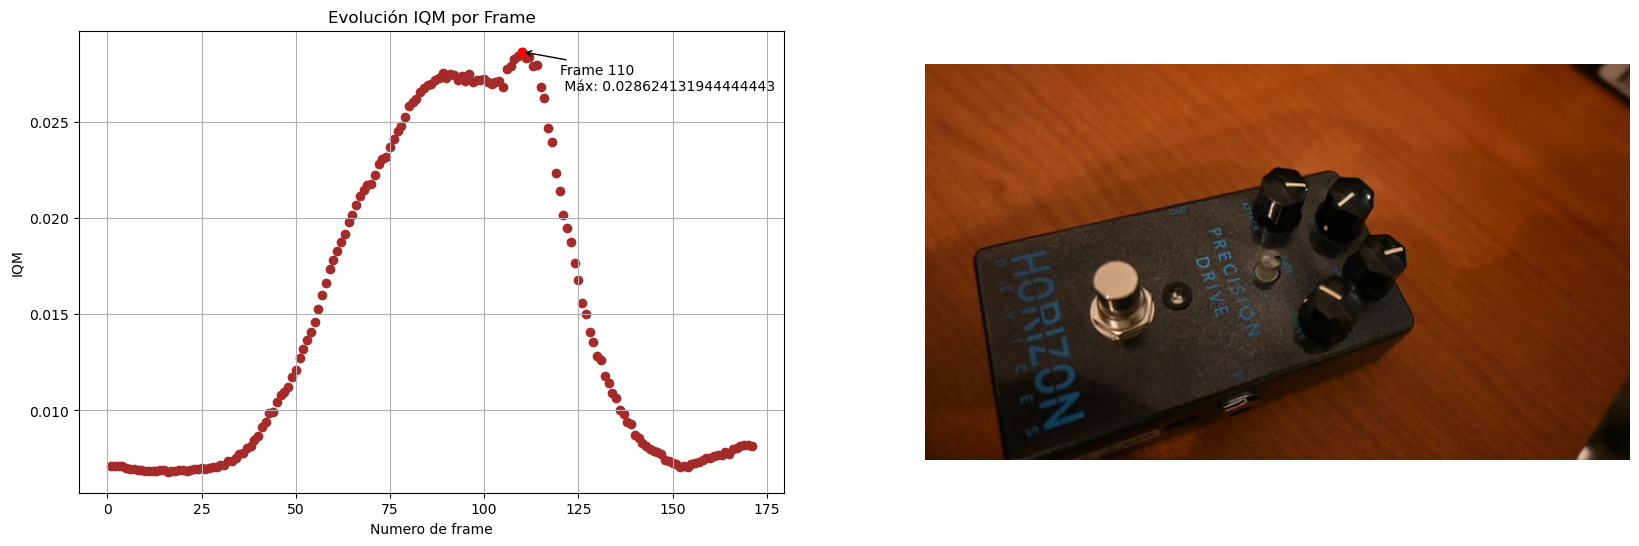

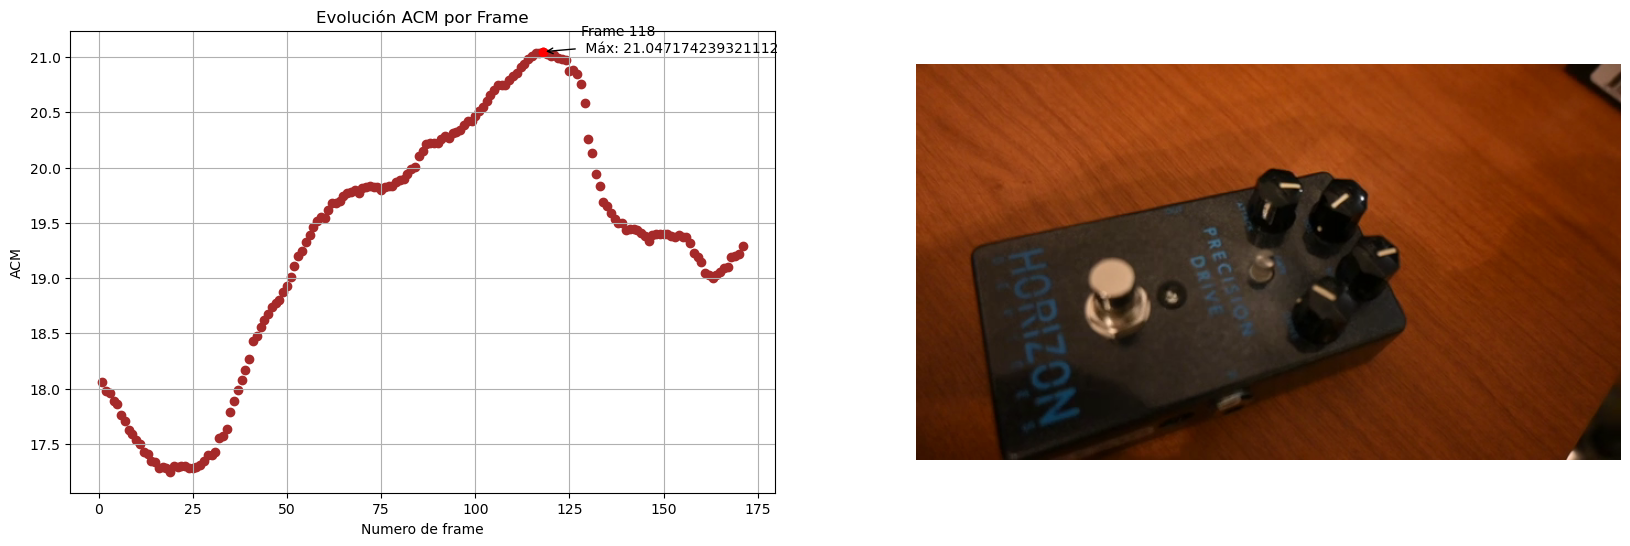

In [13]:
iqm_full_frame_list = procesar_video_completo(video_player, metric=calcular_iqm, name_metric='IQM')
acm_full_frame_list = procesar_video_completo(video_player, metric=calcular_acm, name_metric='ACM')

#### Observación: Nos llama la atención que con la metrica ACM se obtiene un valor maximo en un frame que a la vista se ve desenfocado.

REPRODUCCIÓN VIDEO CON LA EVOLUCIÓN DE LA GRAFICA DE LA MEDICIÓN IQM

In [14]:
def reproducir_video(metric_list):
    matplotlib.use('Agg')
    video_player.unset_roi()
    video_player.unset_matrix()
    video_player.restart()
    delay = int(600 / video_player.fps)

    max_metrix_frame = max(metric_list)
    max_metric_frame_index = metric_list.index(max(metric_list)) + 1
    
    pause_video = False
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos  
        current_frame_index = video_player.get_video_pos()
        if current_frame_index == max_metric_frame_index:
            text=("Frame con mayor enfoque\nFrame: " + 
                  str(max_metric_frame_index) + " Metrica: " + str(max_metrix_frame) +
                  "\nPresiones cualquier tecla para continuar con la reproduccion")
            color= (0, 255, 0)
            osd = OSD(cv2.FONT_ITALIC, color, 0.5, 1)
            osd.draw_text(frame, text)
            pause_video = True 
        # Combina el frame original y la gráfica de la medicion del blur
        img_frame = convert_to_img(metric_list[0:current_frame_index], video_player.shape, video_player.frame_count)
        frame_combined = np.hstack((frame, img_frame))
        # Mostrar el frame combinado
        cv2.imshow('Video', frame_combined)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
        if pause_video:
            pause_video = False
            cv2.waitKey(0)

    cv2.waitKey(0)
    cv2.destroyAllWindows()
    %matplotlib inline

In [15]:
reproducir_video(iqm_full_frame_list)

In [16]:
reproducir_video(acm_full_frame_list)

#### Experimeto 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

In [17]:
def procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=0.05):
    video_player.restart()
    metric_lista = []

    # Calculamos la roi en función del parametro de entrada roi_number
    # video_player.set_roi(roi=roi_number)
    video_player.set_roi(roi=roi_number)
    video_player.osd_on()
    video_player.set_osd_color(color=(0, 255, 0))
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos        
        # Calculamos la metrica
        metric_lista.append(metric(video_player.get_roi_frame()))
    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    max_frame = video_player.get_frame_by_index(max_metric_frame)
    # Graficamos los resultados
    graficar_con_frame(metric_lista, y_label=name_metric,
                       frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

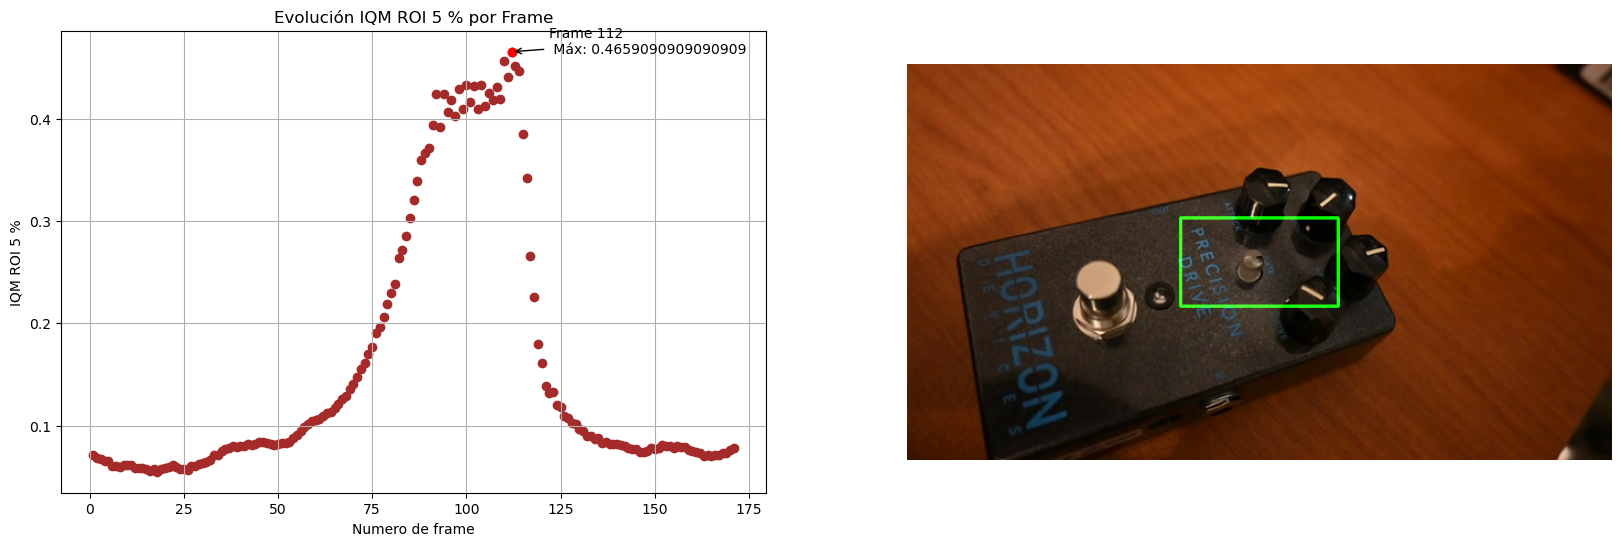

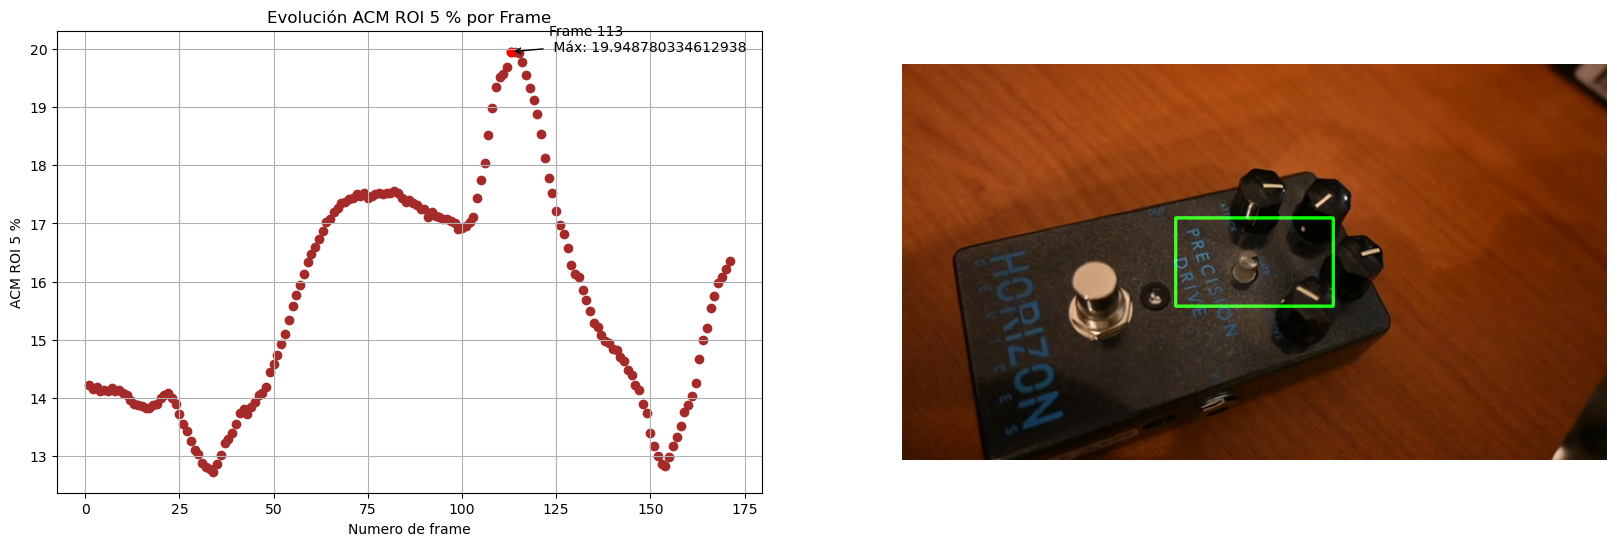

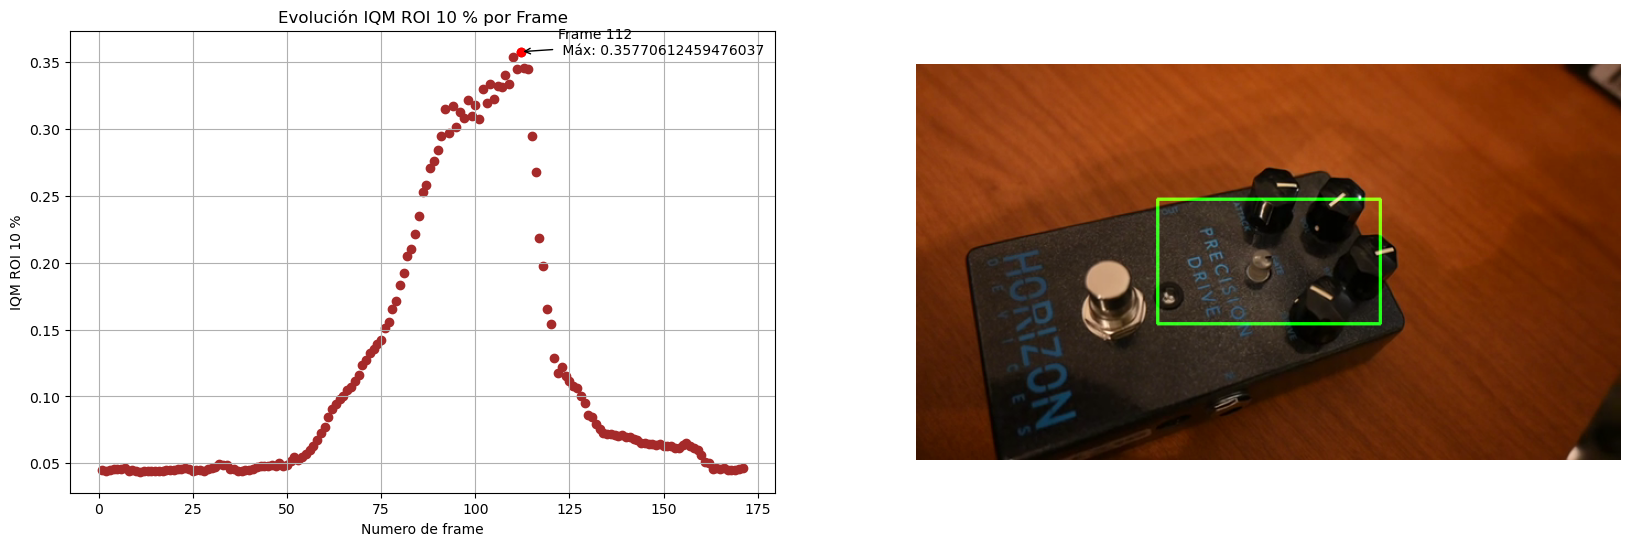

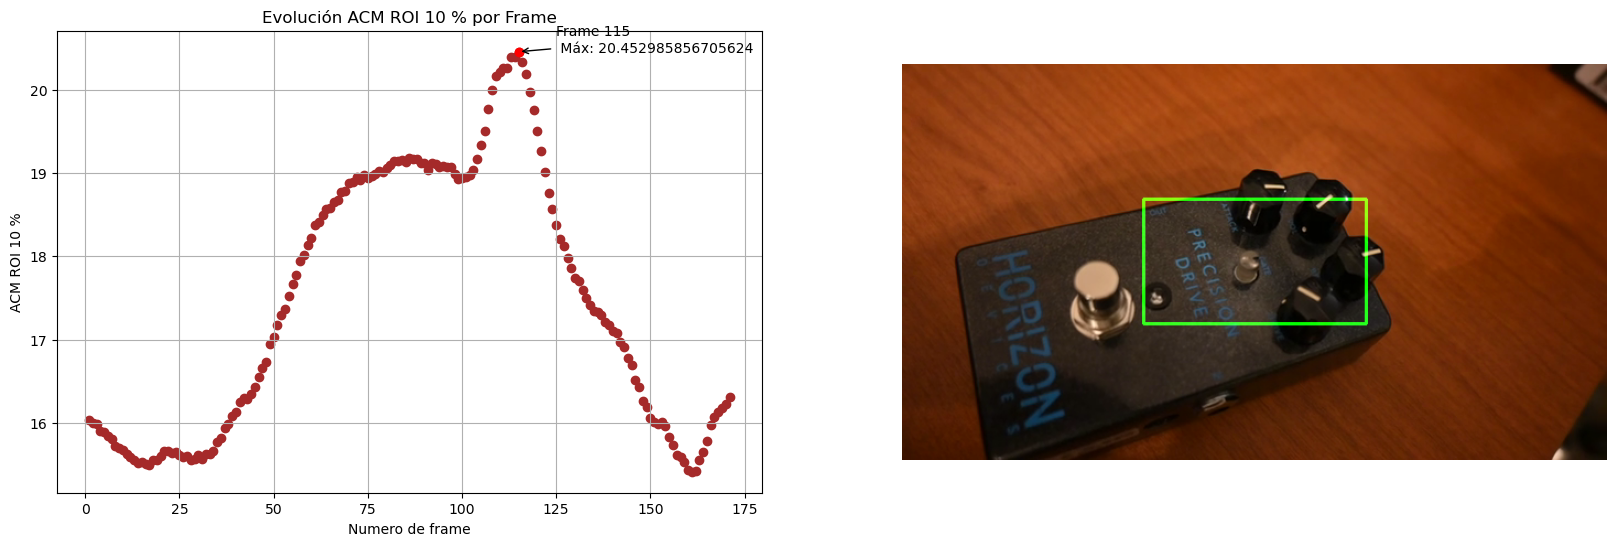

In [18]:
iqm_5_roi_frame_list = procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM ROI 5 %', roi_number=0.05)
acm_5_roi_frame_list = procesar_video_roi(video_player, metric=calcular_acm, name_metric='ACM ROI 5 %', roi_number=0.05)
iqm_10_roi_frame_list = procesar_video_roi(video_player, metric=calcular_iqm, name_metric='IQM ROI 10 %', roi_number=0.1)
acm_10_roi_frame_list = procesar_video_roi(video_player, metric=calcular_acm, name_metric='ACM ROI 10 %', roi_number=0.1)

Reproducción de VIDEO con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque

In [19]:
def reproducir_video_roi(metric_list, roi_number=0.05):
    video_player.restart()
    delay = int(1000 / video_player.fps)

    max_metrix_frame = max(metric_list)
    max_metric_frame_index = metric_list.index(max(metric_list)) + 1
    video_player.set_roi(roi=roi_number)
    video_player.osd_on()
    video_player.set_osd_color(color=(0, 0, 255))
    pause_video = False
    while True:
        current_frame_index = video_player.get_video_pos()
        if current_frame_index+1 == max_metric_frame_index:
            video_player.set_osd_color(color=(0, 255, 0))
            pause_video = True
            
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos  
        
        # Mostrar el frame combinado
        cv2.imshow('Video', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
        if pause_video:
            pause_video = False
            video_player.set_osd_color(color=(0, 0, 255))
            cv2.waitKey(0)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [20]:
reproducir_video_roi(acm_10_roi_frame_list, roi_number=0.1)

#### 3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

In [21]:
def procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM', roi_number=1, height=1, width=1,
                          nrows=3, ncols=3):
    video_player.unset_roi()
    video_player.restart()
    metric_lista = []

    video_player.set_matrix(height=height, width=width, nrows=nrows, ncols=ncols)
    video_player.osd_on()
    video_player.set_osd_color(color=(0, 255, 0))
    while True:
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salir del bucle

        box_list = video_player.get_matrix_frames()

        # Calcular IQM sacando el promedio de las mediciones obtenidas en cada unos de los rectángulos de la matriz
        value_metric = [metric(box) for box in box_list]
        mean_metric = np.mean(value_metric)
        metric_lista.append(mean_metric)

    max_metric_frame = metric_lista.index(max(metric_lista)) + 1
    max_frame = video_player.get_frame_by_index(max_metric_frame)
    # Graficar los resultados
    graficar_con_frame(metric_lista, y_label=name_metric,
                       frame_image=cv2.cvtColor(max_frame, cv2.COLOR_BGR2RGB))
    return metric_lista

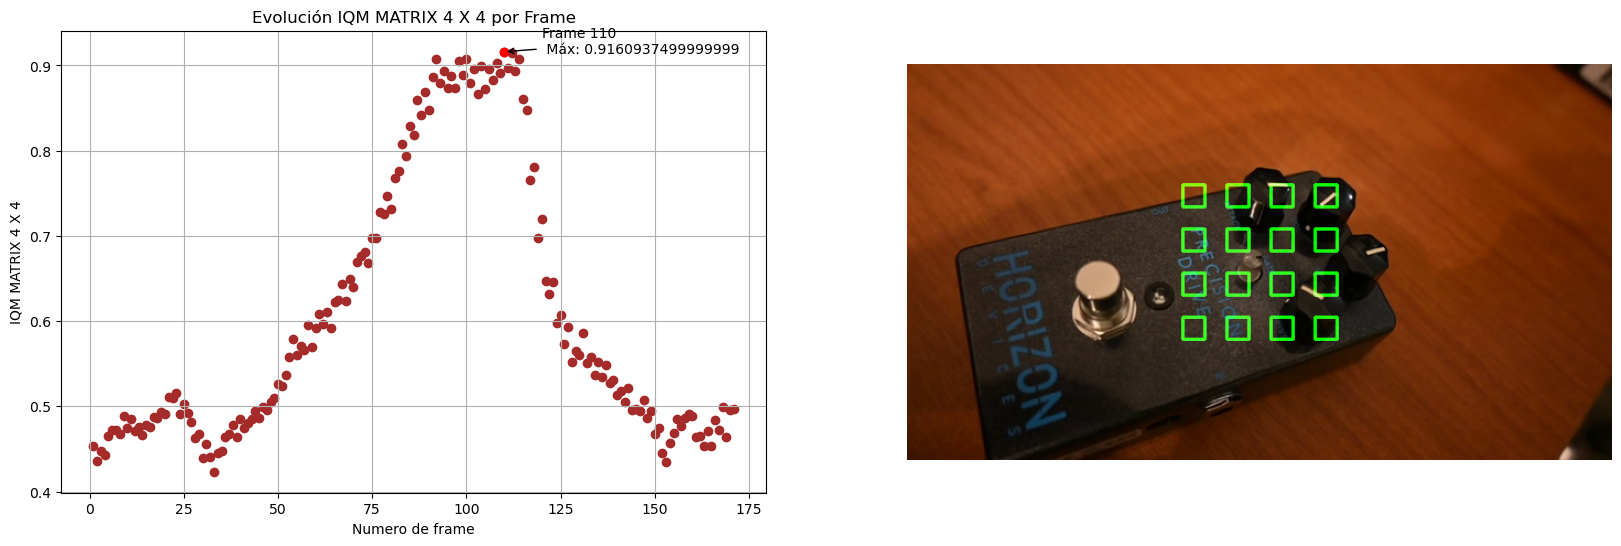

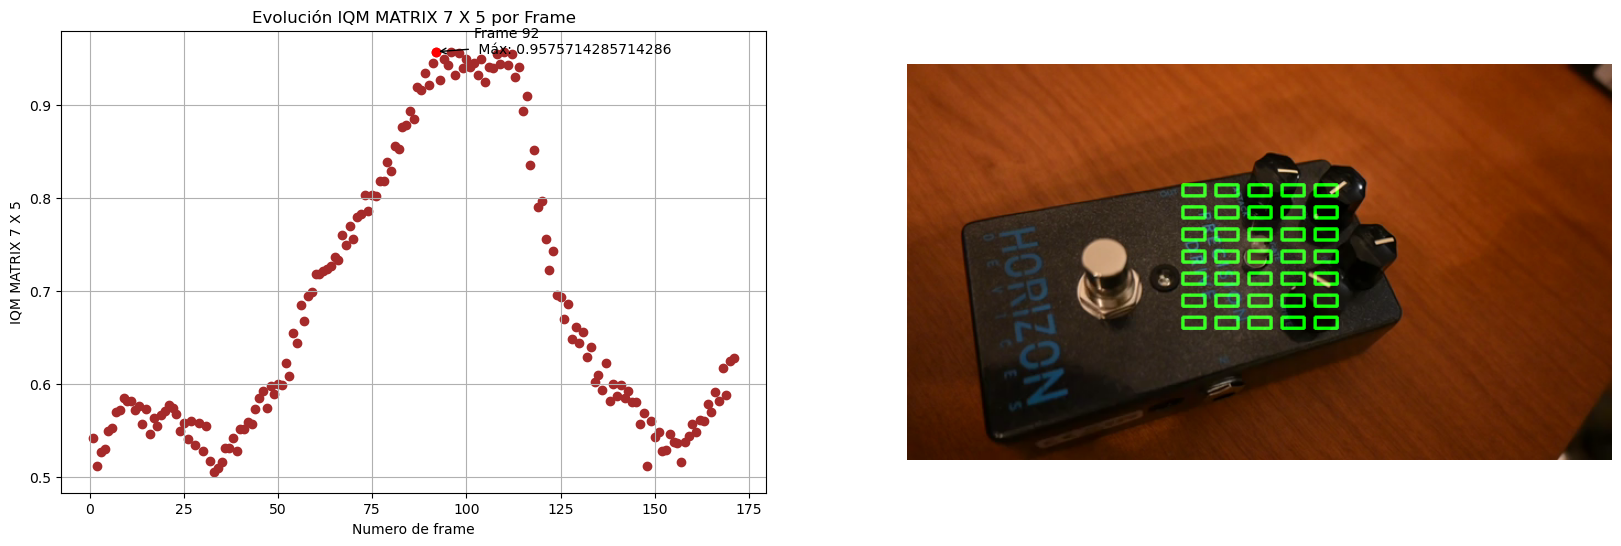

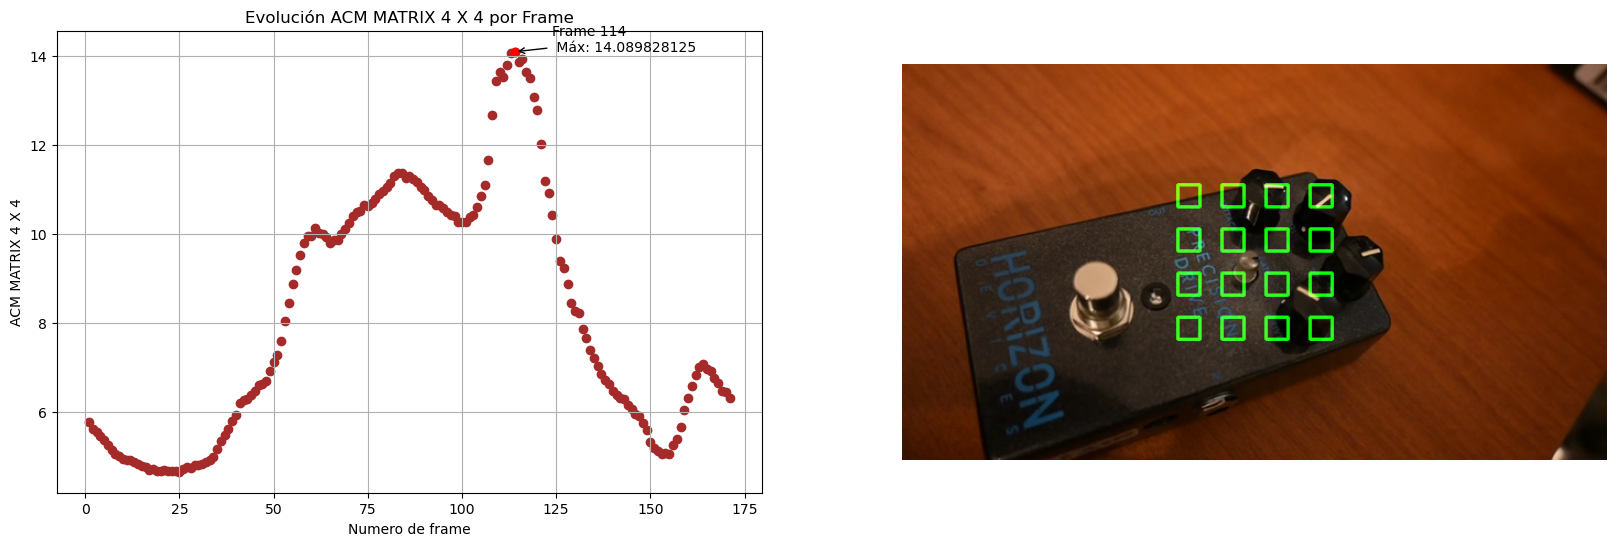

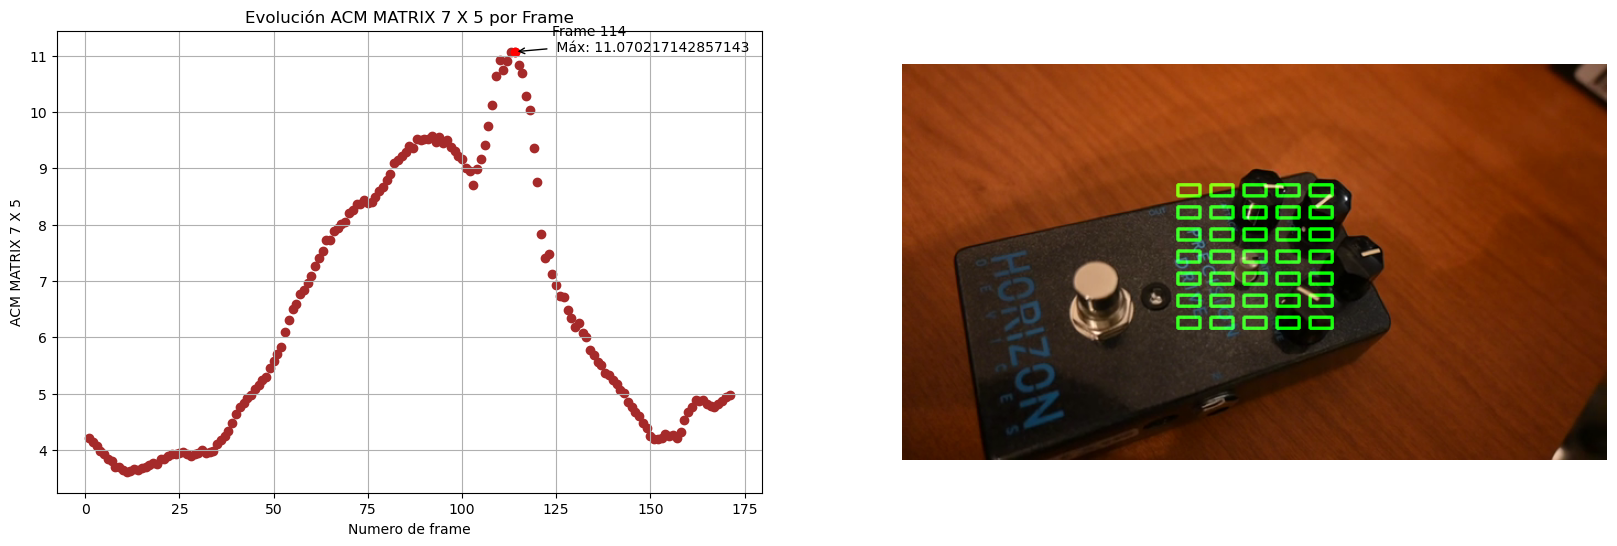

In [22]:
iqm_matrix_4x4_frame_list = procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM MATRIX 4 X 4',
                                                  height=140, width=140, nrows=4, ncols=4)
iqm_matrix_7x5_frame_list = procesar_video_matrix(video_player, metric=calcular_iqm, name_metric='IQM MATRIX 7 X 5',
                                                  height=140, width=140, nrows=7, ncols=5)

acm_matrix_4x4_frame_list = procesar_video_matrix(video_player, metric=calcular_acm, name_metric='ACM MATRIX 4 X 4',
                                                  height=140, width=140, nrows=4, ncols=4)
acm_matrix_7x5_frame_list = procesar_video_matrix(video_player, metric=calcular_acm, name_metric='ACM MATRIX 7 X 5',
                                                  height=140, width=140, nrows=7, ncols=5)

Reproducción de VIDEO con la MATRIZ o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque

In [27]:
def reproducir_video_matrix(metric_list, height=140, width=140, nrows=7, ncols=5):
    video_player.restart()
    delay = int(1000 / video_player.fps)

    max_metric_frame_index = metric_list.index(max(metric_list)) + 1
    video_player.set_matrix(height=height, width=width, nrows=nrows, ncols=ncols)
    video_player.osd_on()
    video_player.set_osd_color(color=(0, 0, 255))
    pause_video = False
    while True:
        current_frame_index = video_player.get_video_pos()
        if current_frame_index+1 == max_metric_frame_index:
            video_player.set_osd_color(color=(0, 255, 0))
            pause_video = True
            
        frame = video_player.get_frame()
        if frame is None:
            break  # Si no hay más frames, salimos  
        
        # Mostrar el frame combinado
        cv2.imshow('Video', frame)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
        if pause_video:
            pause_video = False
            video_player.set_osd_color(color=(0, 0, 255))
            cv2.waitKey(0)

    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [26]:
reproducir_video_matrix(iqm_matrix_7x5_frame_list, nrows=7, ncols=5)

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

### BONUS

UNSHARP MASKING --> algoritmo que tiende a enfocar o mejorar los bordes a traves de un filtro suavizado.
Pasos:
1. Aplicamos un filtro gaussiano para desenfocar
2. Restamos la imagen original con la suavizada para que sobrevivan los componentes de alta frecuencia
3. Agregamos la mascara a la imagen original.

In [25]:
def unsharp_masking(image, sigma=1.0, k=1.5):
    # Aplicar un filtro Gaussiano para obtener la imagen desenfocada
    gauss = cv2.GaussianBlur(image, (0, 0), sigma)

    # Calcular la imagen de la máscara de enfoque (imagen original - imagen desenfocada)
    sharpened = cv2.addWeighted(image, k + 1.0, gauss, -k, 0)

    # Asegurarse de que los valores estén en el rango de 0 a 255
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)

    return sharpened


In [30]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        if activate_um == True:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gris = unsharp_masking(frame_gris, sigma=sigma_um, k=k_um)
        else:
            frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))
        if iqm >= max(iqm_lista):
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

    print(f'Frame de maximo {name_metric} {max_iqm_frame} ({max(iqm_lista)})')
    captura_video.release()

    # Capturamos el video de entrada  
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        if activate_um == True:
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break
            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric}')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

Frame de maximo IQM 110 (0.027842881944444446)


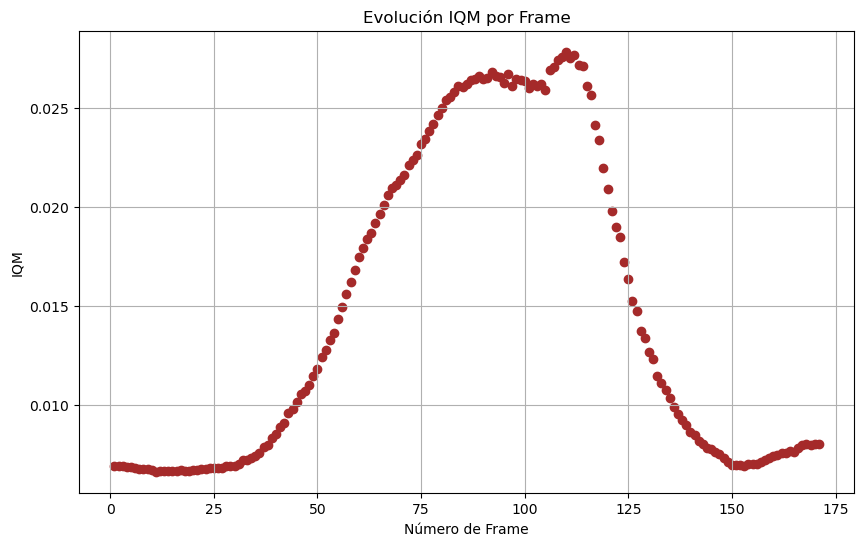

In [28]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1)

Frame de maximo IQM 112 (0.0401171875)


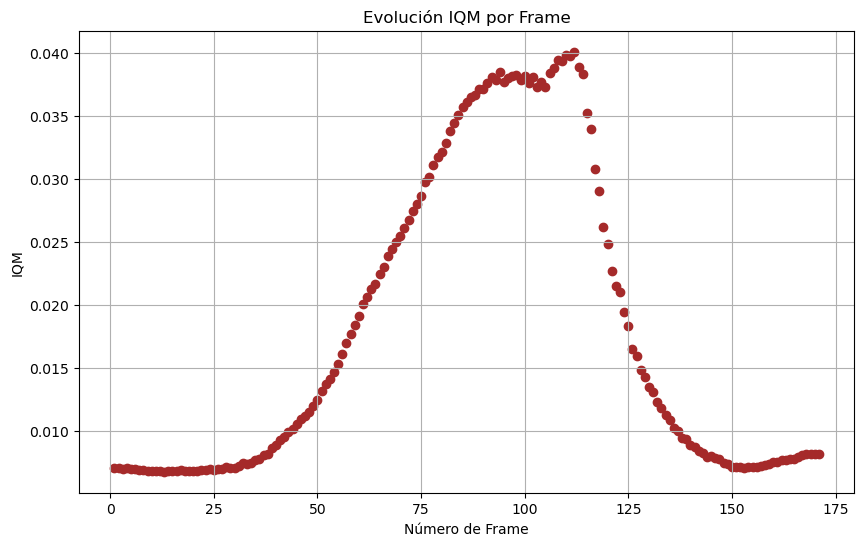

In [31]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1)

Frame de maximo IQM 92 (0.3606727430555556)


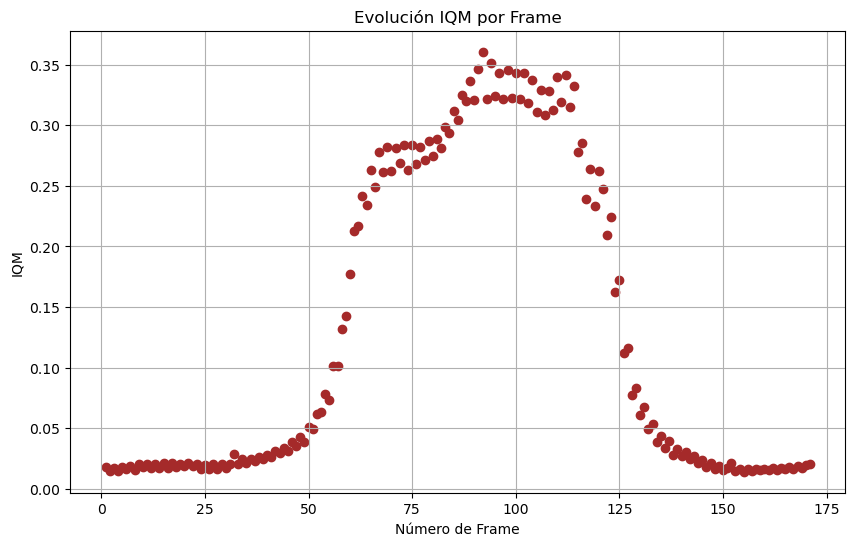

In [32]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20)

APLICANDO EN UNSHARP MASKING SOLO A LOS FRAMES QUE ESTAN ENTRE EL P40 Y P60 DE LA DISTRIBUCION --> aqui lo que sucede es que cuando ponemos un K muy grande, terminamos rompiendo la distribución del IQM

In [33]:
def procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0,
                            k_um=1.5, p_min=40, p_max=60):
    captura_video = cv2.VideoCapture(video_path)
    iqm_lista = []
    frame_numeros = []

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
        return

    # Primera pasada para calcular los IQM
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break  # Si no hay más frames, salir del bucle

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calcular IQM
        iqm = metric(frame_gris)
        iqm_lista.append(iqm)
        frame_numeros.append(int(captura_video.get(cv2.CAP_PROP_POS_FRAMES)))

    captura_video.release()

    # Calcular los percentiles
    iqm_array = np.array(iqm_lista)
    p25, p75 = np.percentile(iqm_array, p_min), np.percentile(iqm_array, p_max)

    # Volver a capturar el video
    captura_video = cv2.VideoCapture(video_path)

    # Comprobamos si el video se abrió correctamente  
    if not captura_video.isOpened():
        print("Error al abrir el video.")
        exit()

    max_iqm_frame = -1
    max_iqm_value = -1
    iqm_final_lista = []  # Lista para IQM combinada

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        frame_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        iqm = metric(frame_gris)

        # Aplicar unsharp masking solo si IQM está entre los percentiles definidos
        if activate_um and (p25 <= iqm <= p75):
            frame_um = unsharp_masking(frame, sigma=sigma_um, k=k_um)
        else:
            frame_um = frame

        # Calcular IQM para el frame procesado (ya sea con o sin unsharp masking)
        iqm_final = metric(cv2.cvtColor(frame_um, cv2.COLOR_BGR2GRAY))
        iqm_final_lista.append(iqm_final)

        # Mostrar el fotograma en una ventana  
        cv2.imshow('Video', frame_um)

        # Actualizar el frame de máximo IQM
        if iqm_final > max_iqm_value:
            max_iqm_value = iqm_final
            max_iqm_frame = int(captura_video.get(cv2.CAP_PROP_POS_FRAMES))

        # Salir si se presiona la tecla 'q'  
        if cv2.waitKey(50) & 0xFF == ord('q'):
            break

            # Liberar recursos  
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.scatter(frame_numeros, iqm_final_lista, color='brown', marker='o')

    # Etiquetas y título
    plt.xlabel('Número de Frame')
    plt.ylabel(f'{name_metric} Final')
    plt.title(f'Evolución {name_metric} por Frame')
    plt.grid(True)
    plt.show()

    print(f'Frame de máximo {name_metric}: {max_iqm_frame} ({max_iqm_value})')

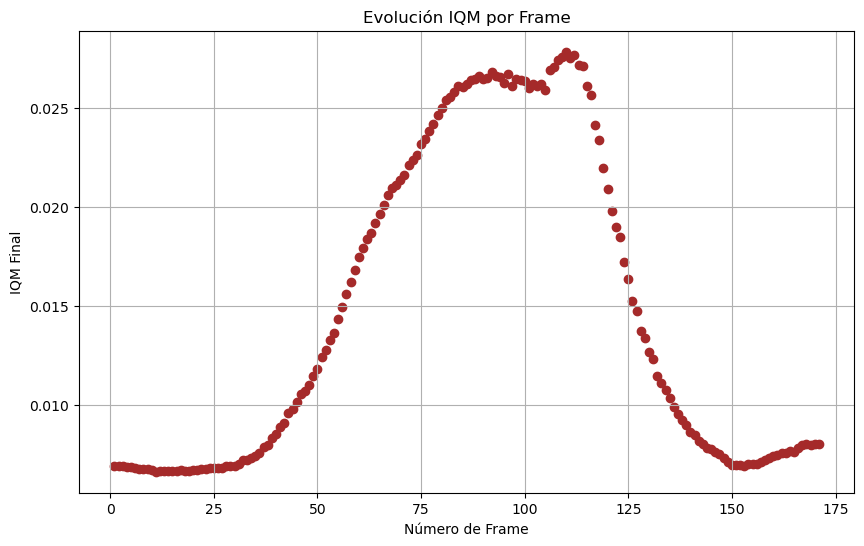

Frame de máximo IQM: 110 (0.027842881944444446)


In [34]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=False, sigma_um=1.0, k_um=1,
                        p_min=25, p_max=75)

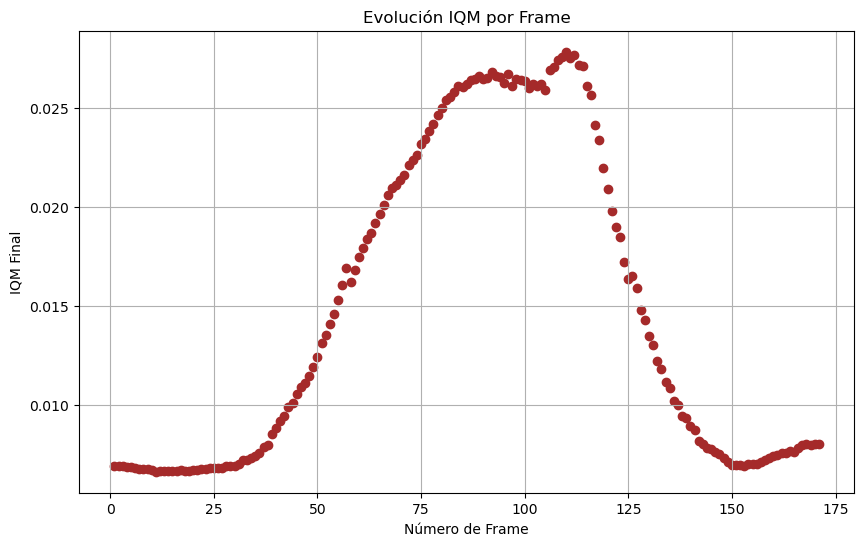

Frame de máximo IQM: 110 (0.027842881944444446)


In [35]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=1,
                        p_min=40, p_max=60)

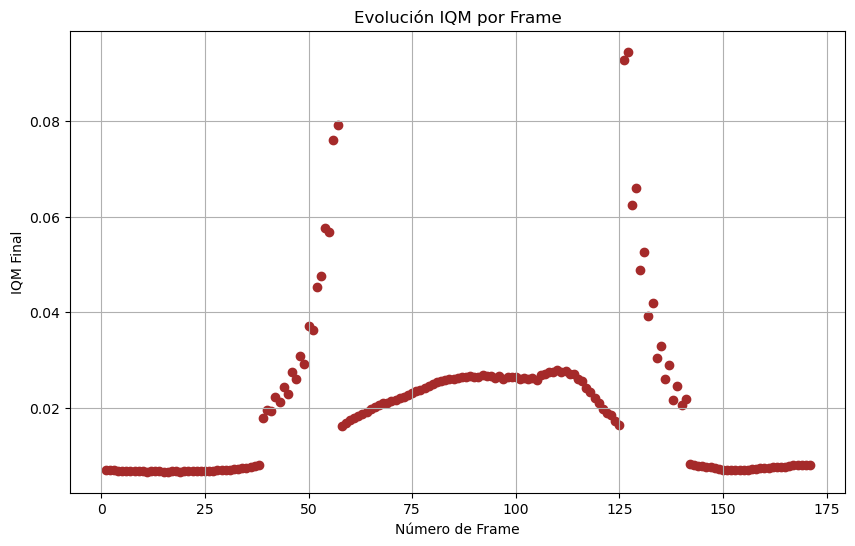

Frame de máximo IQM: 127 (0.09447916666666667)


In [36]:
procesar_video_completo(video_path, metric=calcular_iqm, name_metric='IQM', activate_um=True, sigma_um=1.0, k_um=20,
                        p_min=40, p_max=60)